In [1]:
from utils.models import *
from statsmodels.graphics.tsaplots import plot_acf

# WTI Arbitrage

We know that the no arbitrage condition for a long 1M futures contract is:

$PV(F) - PV(C) - S_0 = 0$

Where $PV()$ denotes the present value function, $F$ denotes 1M futures price and $C$ is the costs accrued at maturity for constructing a replicating portfolio using the underlying asset (e.g. storage costs, insurance). Hence:

$C = FV(PV(F) - S_0)$

Where $FV()$ is the future value function.

We will first find the implied $C$ given by 1M futures. Note that all dollar amounts have been inflation adjusted to current (Nov 2021) values.

In [2]:
df = load('data/wti_arb.csv')

In [3]:
def pv(x, n=1):
    return np.exp(-df.tb3m*n/12) * x

def fv(x, n=1):
    return np.exp(df.tb3m*n/12) * x

In [4]:
cost = fv(pv(df.contract_1) - df.spot)

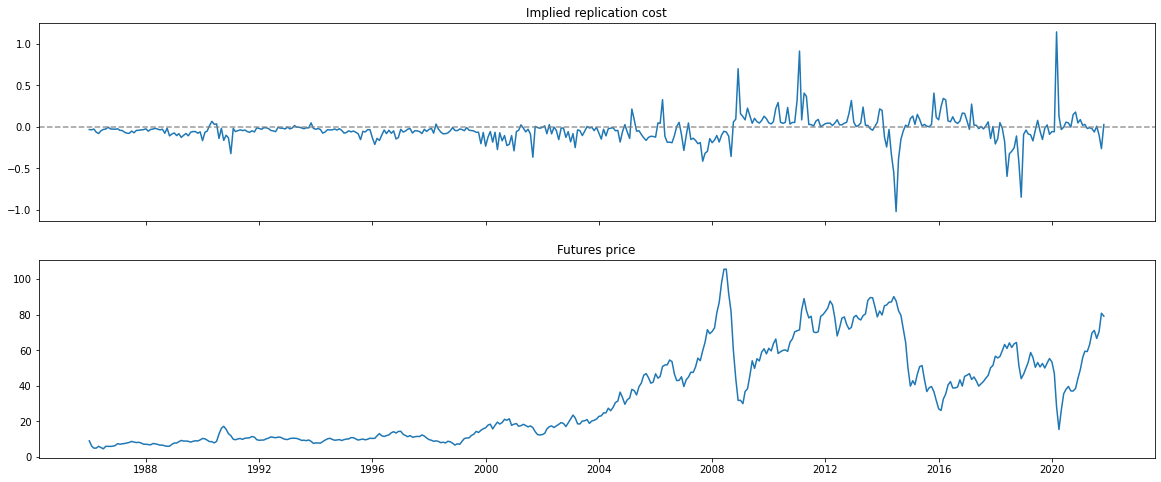

In [5]:
fig, ax = plt.subplots(2, sharex=True, figsize=(20,8))
ax[0].set_title('Implied replication cost')
ax[0].plot(cost)
ax[0].axhline(0, linestyle='--', color='grey', alpha=0.8)
ax[1].set_title('Futures price')
ax[1].plot(df.contract_1)

## Implied Cost Regressions
I wonder if the fluctuations in implied costs of the replicating portfolio can be explained by external shocks.

We will test using the simple regression model

$\%\Delta cost_t = \alpha + \beta S_t + \epsilon$

### VIX

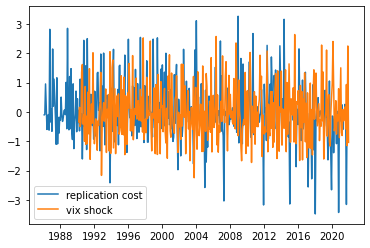

In [6]:
df['rpl_cost'] = cost.pct_change().dropna()
c = clean_series('rpl_cost', df)
vix_shock = clean_series('VIX', load('data/VIX.csv').pct_change().dropna())
plt.plot(c.rpl_cost, label='replication cost')
plt.plot(vix_shock, label='vix shock')
plt.legend()

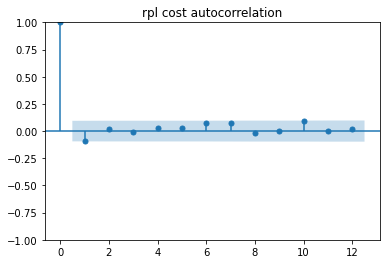

In [7]:
t = plot_acf(c.rpl_cost, lags=12, title='rpl cost autocorrelation')

In [8]:
window = 30 # number of months for measurement sample (lags mean only window-lags datapoints available for each sample)
conf_int = .05 # confidence interval (2-tailed, Student's t)
lags = 0
kalman = KF(window=window, conf_int=conf_int, lags=lags)
kf, confs = kalman.run('rpl_cost', 'VIX', c.join(vix_shock).dropna())

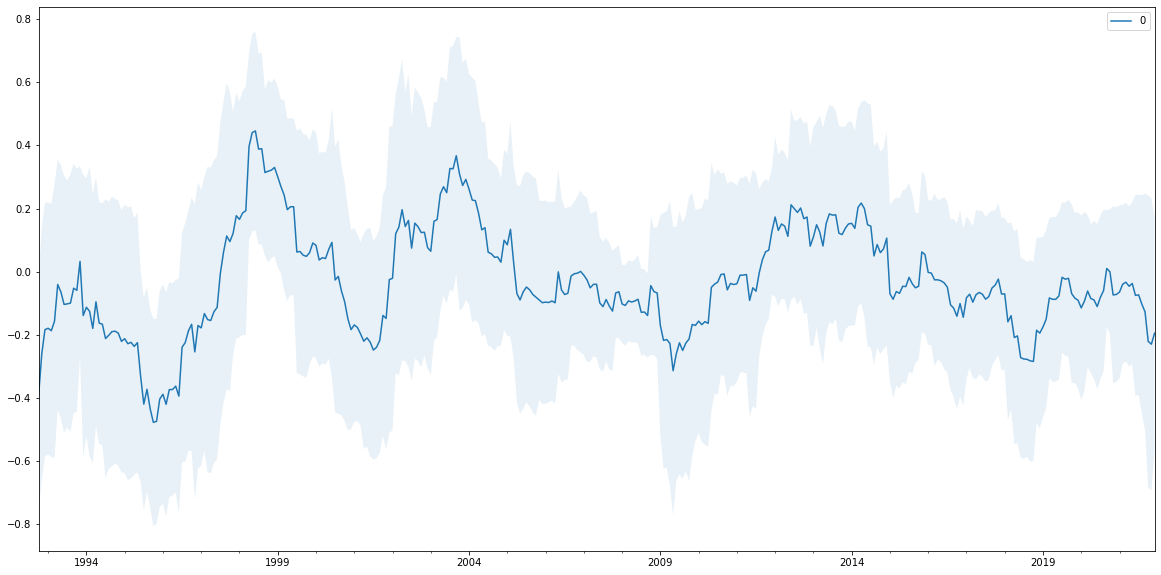

In [9]:
kf.plot(figsize=(20,10))
plt.fill_between(confs.index, confs['lower'], confs['upper'], alpha=0.1)

In [10]:
# print significant results
print(confs[confs['lower'] > 0])
print(confs[confs['upper'] < 0])

               lower     upper
1998-04-01  0.100926  0.691936
1998-05-01  0.127487  0.753301
1998-06-01  0.131986  0.759247
1998-07-01  0.085932  0.690278
1998-08-01  0.085872  0.692807
1998-09-01  0.051785  0.575978
1998-10-01  0.029171  0.606884
1998-11-01  0.043777  0.599145
1998-12-01  0.048769  0.611325
1999-01-01  0.014254  0.586746
               lower     upper
1992-10-01 -0.761987 -0.023975
1995-07-01 -0.756533 -0.082536
1995-08-01 -0.696087 -0.049260
1995-09-01 -0.747653 -0.120825
1995-10-01 -0.805707 -0.148931
1995-11-01 -0.797646 -0.150247
1995-12-01 -0.745322 -0.061485
1996-01-01 -0.736131 -0.040534
1996-02-01 -0.775255 -0.064941
1996-03-01 -0.713441 -0.033533
1996-04-01 -0.709652 -0.037166
1996-05-01 -0.698581 -0.026363
1996-06-01 -0.766898 -0.021450
2008-09-01 -0.272012 -0.005587


In [11]:
dl = DL('rpl_cost', 'VIX', c.join(vix_shock).dropna().iloc[window-lags:], lags=lags)
dl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rpl_cost   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8101
Date:                Sat, 12 Feb 2022   Prob (F-statistic):              0.369
Time:                        18:49:02   Log-Likelihood:                -500.27
No. Observations:                 351   AIC:                             1005.
Df Residuals:                     349   BIC:                             1012.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0269      0.052     -0.515      0.607      -0.130       0.076
VIX-lag0      -0.0454      0.050     -0.900      0.369      -0.145       0.054
==============================================================================
Omnibus:                       21.274   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.900
Skew:                           0.123   Prob(JB):                     2.19e-14
Kurtosis:                       5.059   Cond. No.                         1.05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

<BarContainer object of 1 artists>

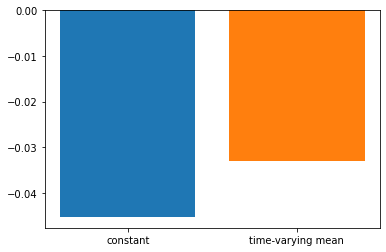

In [12]:
plt.bar('constant', np.cumsum(dl.model.params[1:]))
plt.bar('time-varying mean', kf.mean())

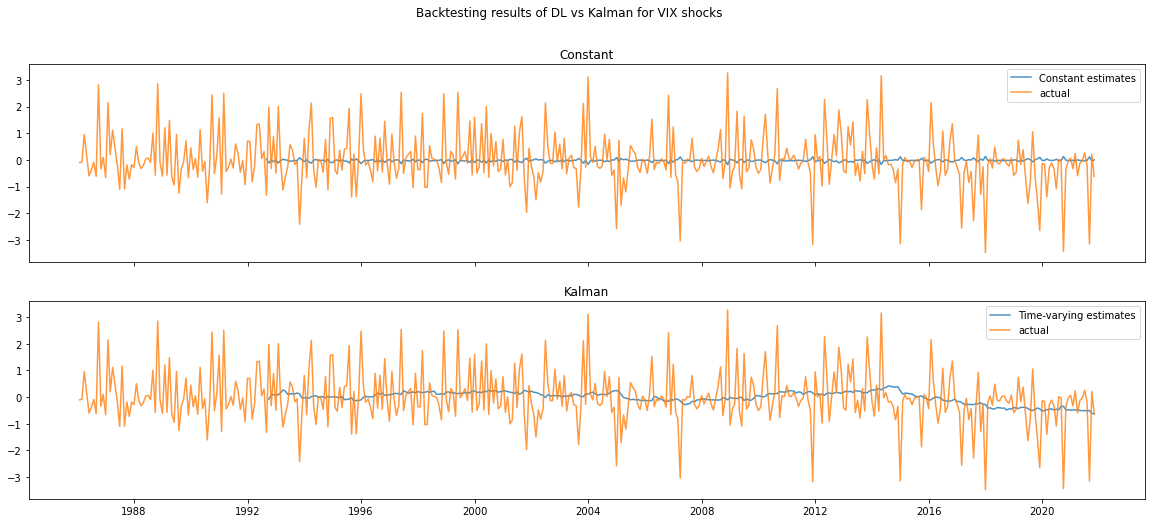

In [13]:
kalman_backtest = kalman.backtest()

x = c.rpl_cost.loc[min(vix_shock.index)+pd.DateOffset(months=window):]
dl_backtest = dl.model.params[0] + x * dl.model.params[1]
for i in range(2, lags+2): # remember params contain constant at [0]
    dl_backtest += x.shift(i-1) * dl.model.params[i]

fig, ax = plt.subplots(2, sharex=True, figsize=(20,8))
fig.suptitle('Backtesting results of DL vs Kalman for VIX shocks')
ax[0].plot(dl_backtest, label='Constant estimates', alpha=0.8)
ax[0].plot(c.rpl_cost, label='actual', alpha=0.8)
ax[0].set_title('Constant')
ax[0].legend()
ax[1].plot(kalman_backtest, label='Time-varying estimates', alpha=0.8)
ax[1].plot(c.rpl_cost, label='actual', alpha=0.8)
ax[1].set_title('Kalman')
ax[1].legend()

In [14]:
rmse_dl = np.sqrt(np.sum((x.loc[min(dl_backtest.index):] - dl_backtest) ** 2) / len(dl_backtest))
rmse_kalman = np.sqrt(np.sum((x.loc[min(kalman_backtest.index):] - kalman_backtest) ** 2) / len(kalman_backtest))
print(f'RMSE DL: {rmse_dl}')
print(f'RMSE Kalman: {rmse_kalman}')

RMSE DL: 1.052988179001665
RMSE Kalman: 1.0052869307806287


### GPR

In [15]:
gpr_shock = clean_series('GPRI', load('data/GPRGlobal.csv').pct_change().dropna())

In [16]:
kf2, confs2 = kalman.run('rpl_cost', 'GPRI', c.join(gpr_shock).dropna())

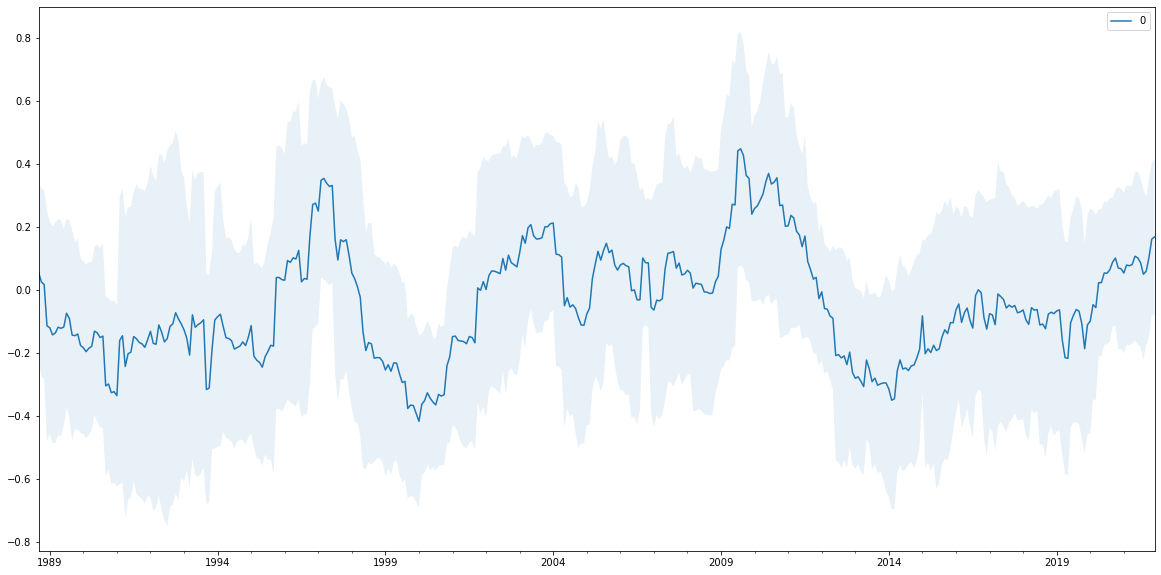

In [17]:
kf2.plot(figsize=(20, 10))
plt.fill_between(confs2.index, confs2['lower'], confs2['upper'], alpha=0.1)

In [18]:
print(confs2[confs2['lower'] > 0])
print(confs2[confs2['upper'] < 0])

               lower     upper
1997-02-01  0.038599  0.656821
1997-03-01  0.033202  0.673973
1997-04-01  0.024428  0.651789
1997-05-01  0.013915  0.642166
1997-06-01  0.023712  0.638681
2009-07-01  0.070220  0.811772
2009-08-01  0.076690  0.818413
2009-09-01  0.069156  0.784433
2009-10-01  0.030918  0.695361
2009-11-01  0.024451  0.682387
               lower     upper
1990-09-01 -0.589723 -0.019750
1990-10-01 -0.571322 -0.026304
1990-11-01 -0.615263 -0.037327
1990-12-01 -0.611935 -0.034240
1991-01-01 -0.623946 -0.048081
1999-09-01 -0.662166 -0.091198
1999-10-01 -0.654065 -0.077233
1999-11-01 -0.657024 -0.077604
1999-12-01 -0.672095 -0.113393
2000-01-01 -0.690472 -0.144058
2000-02-01 -0.587192 -0.139579
2000-03-01 -0.580546 -0.122836
2000-04-01 -0.555113 -0.098433
2000-05-01 -0.571757 -0.115739
2000-06-01 -0.563435 -0.148982
2000-07-01 -0.573027 -0.157324
2000-08-01 -0.557732 -0.106147
2000-09-01 -0.556492 -0.117786
2000-10-01 -0.556393 -0.109252
2013-03-01 -0.577175 -0.003378
2013-04-

In [19]:
dl2 = DL('rpl_cost', 'GPRI', c.join(gpr_shock).dropna().iloc[window-lags:], lags=lags)
dl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               rpl_cost   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7509
Date:                Sat, 12 Feb 2022   Prob (F-statistic):              0.387
Time:                        18:49:07   Log-Likelihood:                -569.05
No. Observations:                 400   AIC:                             1142.
Df Residuals:                     398   BIC:                             1150.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0062      0.048     -0.129      0.897      -0.101       0.088
GPRI-lag0     -0.0448      0.052     -0.867      0.387      -0.147       0.057
==============================================================================
Omnibus:                       23.512   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.851
Skew:                           0.173   Prob(JB):                     5.02e-15
Kurtosis:                       4.957   Cond. No.                         1.05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

<BarContainer object of 1 artists>

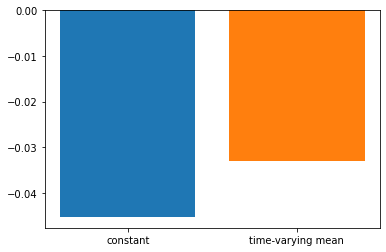

In [20]:
plt.bar('constant', np.cumsum(dl.model.params[1:]))
plt.bar('time-varying mean', kf.mean())

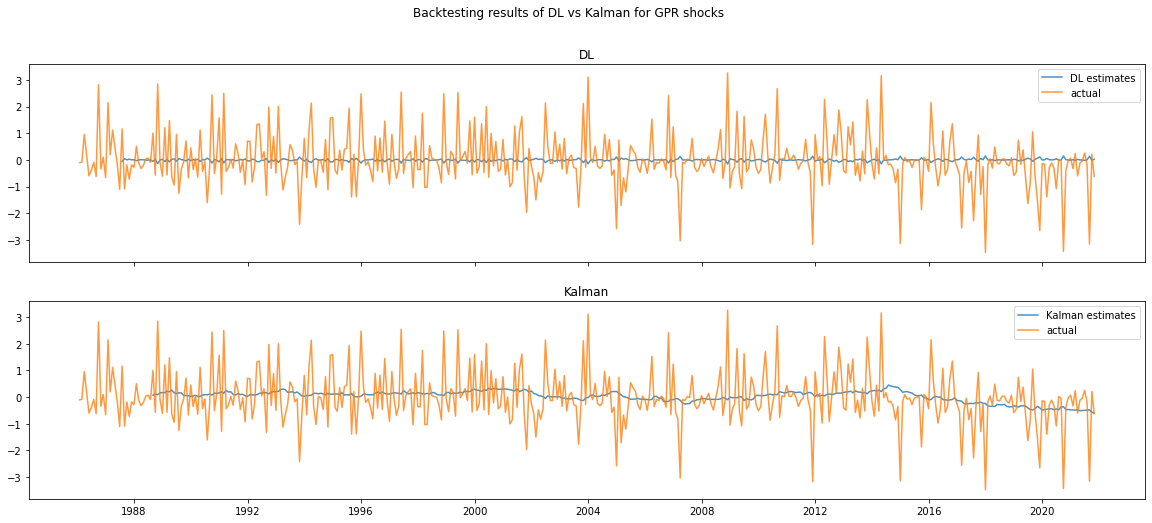

In [21]:
kalman_backtest2 = kalman.backtest()

x2 = c.rpl_cost.loc[min(gpr_shock.index)+pd.DateOffset(months=window):]
dl_backtest2 = dl2.model.params[0] + x2 * dl2.model.params[1]
for i in range(2, lags+2): # remember params contain constant at [0]
    dl_backtest2 += x2.shift(i-1) * dl2.model.params[i]

fig, ax = plt.subplots(2, sharex=True, figsize=(20,8))
fig.suptitle('Backtesting results of DL vs Kalman for GPR shocks')
ax[0].plot(dl_backtest2, label='DL estimates', alpha=0.8)
ax[0].plot(c.rpl_cost, label='actual', alpha=0.8)
ax[0].set_title('DL')
ax[0].legend()
ax[1].plot(kalman_backtest2, label='Kalman estimates', alpha=0.8)
ax[1].plot(c.rpl_cost, label='actual', alpha=0.8)
ax[1].set_title('Kalman')
ax[1].legend()

In [22]:
rmse_dl2 = np.sqrt(np.sum((x.loc[min(dl_backtest2.index):] - dl_backtest2) ** 2) / len(dl_backtest2))
rmse_kalman2 = np.sqrt(np.sum((x.loc[min(kalman_backtest2.index):] - kalman_backtest2) ** 2) / len(kalman_backtest2))
print(f'RMSE DL: {rmse_dl2}')
print(f'RMSE Kalman: {rmse_kalman2}')

RMSE DL: 0.9716318293197796
RMSE Kalman: 0.9429605160303558
